In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

In [6]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


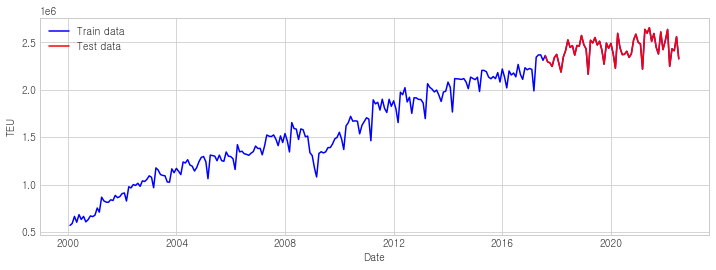

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [9]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [11]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [12]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [13]:
raw_df = data

In [14]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

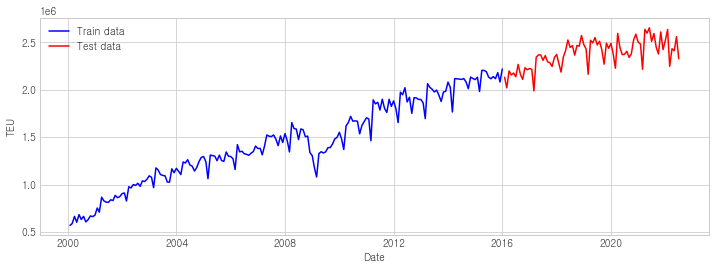

In [15]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [16]:
len(train),len(test)

(192, 78)

In [17]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [19]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [20]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 36   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [21]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [22]:
X_train.shape,Y_train.shape

((139, 18, 1), (139, 36, 1))

### 2. X_test,Y_test 배열

In [23]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_test.shape,Y_test.shape

((25, 18, 1), (25, 36, 1))

In [25]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [26]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(Conv1D(filters=48, kernel_size=2,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]),padding='causal',name='extractor'))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(Flatten())
model.add(RepeatVector(36)) # 출력 개수만큼 반복 

## Decoder State
model.add(LSTM(66, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 5s 257ms/step - loss: 0.2955 - mae: 0.4858 - val_loss: 0.1762 - val_mae: 0.3515
Epoch 2/200
14/14 [==============================] - 0s 24ms/step - loss: 0.1271 - mae: 0.2841 - val_loss: 0.1913 - val_mae: 0.3730
Epoch 3/200
14/14 [==============================] - 0s 22ms/step - loss: 0.0806 - mae: 0.2256 - val_loss: 0.1823 - val_mae: 0.3710
Epoch 4/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0627 - mae: 0.1953 - val_loss: 0.2164 - val_mae: 0.4131
Epoch 5/200
14/14 [==============================] - 0s 21ms/step - loss: 0.0586 - mae: 0.1889 - val_loss: 0.0853 - val_mae: 0.2361
Epoch 6/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0446 - mae: 0.1655 - val_loss: 0.1066 - val_mae: 0.2763
Epoch 7/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0458 - mae: 0.1648 - val_loss: 0.0939 - val_mae: 0.2517
Epoch 8/200
14/14 [==============================] - 0s 19ms/step - loss: 0

In [27]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

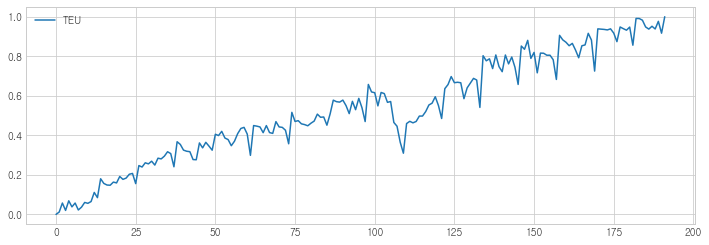

In [28]:
label_train.plot()

<AxesSubplot:>

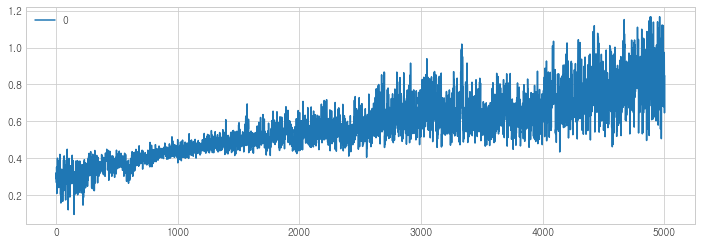

In [29]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### 1. 2017.07 ~ 2020.06

In [30]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 1)) 

In [31]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [32]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

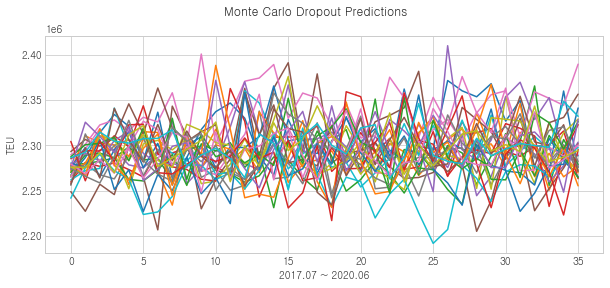

In [33]:
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2020.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [34]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [35]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [36]:
np.mean(df.std()/df.mean())

0.011601891368627548

In [37]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 117479.59936565765
MAPE: 4.462601820647757


In [38]:
rmse = math.sqrt(mean_squared_error(trend[0:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:36].reset_index()['TEU_Trend'])*100) )

RMSE: 119394.22121987294
MAPE: 4.531766893168442


In [39]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.head(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2267100.0,2272108.5,2277967.5,2259536.75,2273247.75,2248760.0,2289534.5,2265271.75,2266477.25,2261759.5,2275611.25,2270350.25,2270201.5,2285324.5,2276778.5,2293089.5,2264863.5,2255865.75,2276523.0,2241544.5,2280359.0,2278624.25,2287422.75,2304399.0,2275067.75,2257159.5,2279533.5,2274394.0,2275810.25,2286276.5


In [40]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 151440.54843733233
Mean MAPE: 5.356105060820189


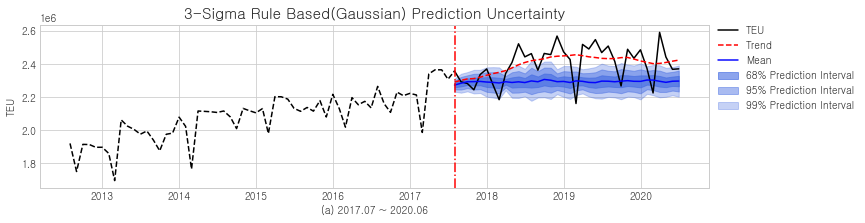

In [41]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=15)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().mean())/ test_data.head(36).reset_index()['TEU'])*100) )

In [42]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.1388888888888889

In [43]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.08333333333333333

Median RMSE: 152342.36570204113
Median MAPE: 5.381871953850447


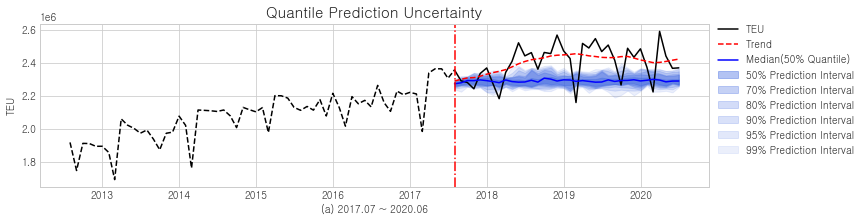

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2020.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=15)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[150:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:246], 'black', label='TEU')
plt.plot(trend.head(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(36).reset_index()['TEU']- df.transpose().median())/ test_data.head(36).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.1111111111111111

In [46]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.027777777777777776

In [47]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 58991.61
Quantile 70% Interval Sharpness 56811.64583333339


In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.19444444444444445

In [49]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 117983.28
Quantile 95% Interval Sharpness 104495.19965277771
Min Max Interval Sharpness 127406.664


In [50]:
import CRPS.CRPS as pscore

In [51]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

78225.0375
5973.203055555557
7774.9319444444445
36363.78833333335
29490.831388888888
62913.43944444444
10402.056111111113
83631.18305555552
40963.98527777778
105355.41111111111
213199.92194444445
140729.27222222224
143308.34055555554
53735.631944444445
137809.82972222223
134242.21277777778
262349.63416666666
162236.95444444445
121127.33499999999
121563.41416666667
210081.16749999998
186577.25805555558
243315.73777777777
153330.76249999998
196243.43722222222
107406.92555555556
16745.73027777778
172638.7238888889
122059.54972222222
170899.29833333334
55653.773888888885
61466.51638888889
278520.73555555556
137188.58333333334
57339.83472222222
58540.87611111111


In [52]:
a = np.array([78225.0375,
5973.203055555557,
7774.9319444444445,
36363.78833333335,
29490.831388888888,
62913.43944444444,
10402.056111111113,
83631.18305555552,
40963.98527777778,
105355.41111111111,
213199.92194444445,
140729.27222222224,
143308.34055555554,
53735.631944444445,
137809.82972222223,
134242.21277777778,
262349.63416666666,
162236.95444444445,
121127.33499999999,
121563.41416666667,
210081.16749999998,
186577.25805555558,
243315.73777777777,
153330.76249999998,
196243.43722222222,
107406.92555555556,
16745.73027777778,
172638.7238888889,
122059.54972222222,
170899.29833333334,
55653.773888888885,
61466.51638888889,
278520.73555555556,
137188.58333333334,
57339.83472222222,
58540.87611111111])

In [53]:
np.mean(a)

116094.59236111112

### 2. 2019.07 ~ 2022.06

In [54]:
X_test_2 = np.array(feature_test[24:42]).reshape((1, 18, 1)) 

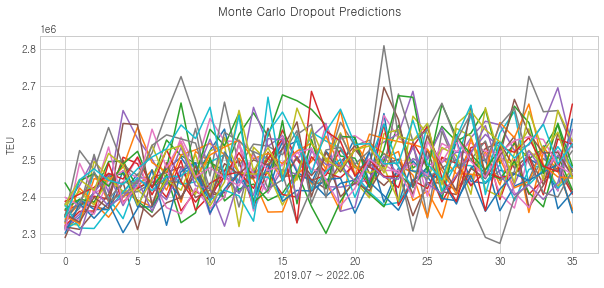

In [55]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,1, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    #model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 10, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2022.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [56]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [57]:
np.mean(df.std()/df.mean())

0.02863057143986225

In [58]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().mean())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 36791.18540872002
MAPE: 1.2098696090019765


In [59]:
rmse = math.sqrt(mean_squared_error(trend.tail(36).reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.tail(36).reset_index()['TEU_Trend']- df.transpose().median())/ trend.tail(36).reset_index()['TEU_Trend'])*100) )

RMSE: 34665.41831415641
MAPE: 1.1447609054536096


In [60]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.tail(36)

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2315065.75,2340443.75,2438546.0,2364472.0,2381986.25,2290836.5,2325684.75,2350022.75,2329778.25,2313925.5,2335486.75,2330966.25,2367505.0,2322908.75,2319229.0,2319747.5,2399783.5,2333562.5,2376026.25,2379007.0,2302631.5,2348377.0,2347985.75,2388686.25,2317927.0,2353389.25,2311046.25,2348825.25,2379551.5,2345091.0


In [61]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
#data = data.iloc[:246]
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 117504.08971853531
Mean MAPE: 4.002569027930628


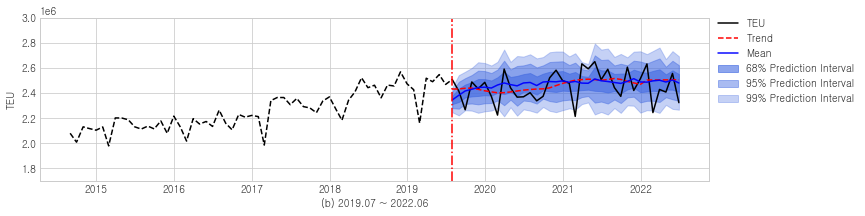

In [62]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,3.0e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='royalblue', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='royalblue',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [63]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.7777777777777778


In [64]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

추세 변동에 대한 포함확률: 0.9444444444444444


Median RMSE: 115486.98844604446
Median MAPE: 3.9435813347551605


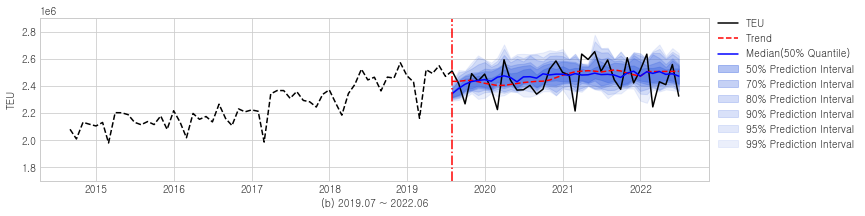

In [65]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2019.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[175:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:], 'black', label='TEU')
plt.plot(trend.tail(36),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='royalblue', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='royalblue', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='royalblue', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='royalblue', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='royalblue', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='royalblue', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(36).reset_index()['TEU'], df.transpose().median()))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(36).reset_index()['TEU']- df.transpose().median())/ test_data.tail(36).reset_index()['TEU'])*100) )

In [66]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.6388888888888888

In [67]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(36).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.9166666666666666

In [68]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 140107.5
Quantile 70% Interval Sharpness 136871.63576388892


In [69]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(36).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.7222222222222222

In [70]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,36):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 280214.88
Quantile 95% Interval Sharpness 248904.33506944444
Min Max Interval Sharpness 291190.9


In [71]:
crps = []

for i in range(0,36):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(36).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

145912.7136111111
23801.845555555552
121395.05305555556
39822.58583333333
14208.47138888889
28591.034166666668
37477.81305555556
206931.15694444452
75484.31916666665
16425.29222222222
48172.15111111111
75223.10250000001
48278.36944444444
83447.59138888889
79028.47694444444
26526.112222222222
58648.194166666675
22728.428333333333
16173.372777777779
237015.3719444444
122654.245
86317.52972222221
102618.56527777777
22062.80472222222
64148.28805555556
23744.507500000003
62264.98694444445
77391.20166666666
58037.750555555554
23573.42138888889
104802.5561111111
209061.10611111112
40817.70638888889
50240.015277777784
37131.49861111111
118034.93722222223


In [72]:
a = np.array([145912.7136111111,
23801.845555555552,
121395.05305555556,
39822.58583333333,
14208.47138888889,
28591.034166666668,
37477.81305555556,
206931.15694444452,
75484.31916666665,
16425.29222222222,
48172.15111111111,
75223.10250000001,
48278.36944444444,
83447.59138888889,
79028.47694444444,
26526.112222222222,
58648.194166666675,
22728.428333333333,
16173.372777777779,
237015.3719444444,
122654.245,
86317.52972222221,
102618.56527777777,
22062.80472222222,
64148.28805555556,
23744.507500000003,
62264.98694444445,
77391.20166666666,
58037.750555555554,
23573.42138888889,
104802.5561111111,
209061.10611111112,
40817.70638888889,
50240.015277777784,
37131.49861111111,
118034.93722222223])

In [73]:
np.mean(a)

72449.79378858025

In [74]:
(77581.77+94272.19+104485.19)/3

92113.05